## Introduction

This notebook generates book recommendations using two methods: collabortive filtering based on reader similarity and collaborative filtering based on predicted book ratings. The former uses KNN while the latter uses two forms of matrix factorization - first by singular value decomposition (SVD) and next by gradient descent using alternating least squares (ALS). 

Book and user ratings data come from the [Goodreads Book Graph Datasets](https://github.com/MengtingWan/goodreads]) produced by Mengting Wan, Rishabh Misra, Ndapa Nakashole, and Julian McAuley at UCSD. It has been imported, cleaned, and preprocessed in [00_prep_goodreads_data.ipynb](https://github.com/mraottth/projects/blob/main/Goodreads%20Book%20Recommender/00_prep_goodreads_data.ipynb). Genres, which are important for filtering recommendations but missing from the UCSD dataset, are inferred by topic modeling via latent dirichlet allocation (LDA) on book descriptions in [01_infer_genres.ipynb](https://github.com/mraottth/projects/blob/main/Goodreads%20Book%20Recommender/01_infer_genres.ipynb).

The target reader, for whom recommendations are being made in this notebook, is myself. To substitute your own Goodreads data and get personalized recommendations, go to the [Import/Export](https://www.goodreads.com/review/import) page on your Goodreads profile, download your books, and save as ```./data/goodreads_library_export.csv``` 

#### Contents

<a href='#Part0'>Part 0: Preprocessing:</a>
- <a href='#Part0.1'>0.1</a> - Load and Prepare Data
- <a href='#Part0.2'>0.2</a>  - Write Functions to Process Recommendations

<a href='#Part1'>Part 1: Collaborative Filtering Based on Reader Similarity with KNN</a>
- <a href='#Part1.1'>1.1</a> - Find Similar Readers
- <a href='#Part1.2'>1.2</a> - Generate Recommendations

<a href='#Part2'>Part 2: Collaborative Filtering Based on Predicted Ratings with Matrix Factorization</a>
- <a href='#Part2.1'>2.1</a> - Factorize User-Rating Matrix with SVD
- <a href='#Part2.2'>2.2</a> - Generate Recommendations by Predicting Ratings
- <a href='#Part2.3'>2.3</a> - Matrix Factorization with Gradient Descent

<a id='Part0'></a>
## Part 0: Preprocessing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Normalizer
from IPython.display import display
from scipy.sparse.linalg import svds

### 0.1 - Load and Prepare Data

In [3]:
# Load df_books and genres
wd = os.getcwd()
df_books = pd.read_csv(wd + "/data/goodreads_books.csv")
df_inferred_genres = pd.read_csv(wd + "/data/inferred_genres.csv")
genre_descriptors = pd.read_csv(wd + "/data/inferred_genre_top_words.csv")

# Join genres to books
df_books = pd.merge(df_books, df_inferred_genres.drop(columns="title"), how="left", on="book_id")

In [4]:
# Load sparse_reviews from file
df_reviews = sparse.load_npz(wd + "/data/user_reviews.npz")

# Load user (rows) and book (cols) indices
user_index = pd.read_csv(wd + "/data/user_index_for_sparse_matrix.csv").rename(columns={"0":"user_id"})
book_index = pd.read_csv(wd + "/data/book_index_for_sparse_matrix.csv").rename(columns={"0":"book_id"})

In [5]:
# Load my goodreads history
my_books = pd.read_csv(wd + "/data/goodreads_library_export.csv")

# Filter to books I've rated
my_books = my_books[["Book Id", "My Rating", "Title"]]\
    .rename(columns={"Book Id":"book_id", "My Rating":"rating", "Title":"title"}).query("rating > 0")
print(f"Target reader ratings: {my_books.shape[0]}")

# Reformat to fit sparse matrix
my_books_1 = pd.merge(
                my_books, df_books[["book_id", "title"]], 
                how="left", on="book_id", suffixes=["_mb","_dfb"]
            )
my_books_id_match = my_books_1[~my_books_1["title_dfb"].isna()]
print(f"Matching on book_id: {my_books_id_match.shape[0]}")

my_books_2 = pd.merge(
    my_books_1[my_books_1["title_dfb"].isna()], df_books[["book_id", "title"]], 
    how="left", left_on="title_mb", right_on="title", suffixes=["_mb","_dfb"]
    )
my_books_match_on_title = my_books_2[~my_books_2["title"].isna()]
print(f"Matching on title: {my_books_match_on_title.shape[0]}")

my_books_id_match = my_books_id_match[["book_id", "rating", "title_dfb"]]\
                        .rename(columns={"title_dfb":"title"})
my_books_match_on_title = my_books_match_on_title[["book_id_dfb", "rating", "title"]]\
                        .rename(columns={"book_id_dfb":"book_id"})

my_books_3 = pd.concat([my_books_id_match, my_books_match_on_title])
my_books_3 = my_books_3.drop_duplicates(subset="book_id")
print(f"Total matches: {my_books_3.shape[0]}, {(my_books_3.shape[0] / my_books.shape[0]):.2%} of total")

my_books_4 = pd.merge(book_index, my_books_3, how="left", on="book_id").fillna(0.)
my_books = np.array(my_books_4["rating"]).reshape(1,-1)

# Add to sparse matrix
df_reviews = sparse.vstack([df_reviews, my_books])
df_reviews = sparse.csr_matrix(df_reviews)

# Normalize reviews within readers for KNN
norm = Normalizer()
df_reviews_norm = norm.fit_transform(df_reviews) 

Target reader ratings: 168
Matching on book_id: 32
Matching on title: 65
Total matches: 97, 57.74% of total


In [6]:
# Set target reader to make recommendations for
target = df_reviews.shape[0] - 1

#### 0.2 - Write Functions to Process Recommendations

In [7]:
# Function to use KNN to find similar users
def find_neighbors(n_neighbors, target_user, ratings_df, ind_books, books):

    # Instantiate KNN
    n_neighbors = n_neighbors

    nn_model = NearestNeighbors(
        metric="cosine",
        algorithm="auto",
        n_neighbors=n_neighbors,
        n_jobs=-1
    )

    # Fit to sparse matrix
    nn_model.fit(ratings_df)

    # Feed in user and get neighbors and distances
    reader = ratings_df[target,:].toarray()
    dists, neighbors = nn_model.kneighbors(reader, return_distance=True)

    similar_users = pd.DataFrame(
        [pd.Series(neighbors.reshape(-1)), pd.Series(dists.reshape(-1))]).T.rename(
            columns={0:"user", 1:"distance"}
    )

    # Get all books read by similar users
    book_ind = []
    book_rat = []
    uid = []
    target_user_books = []
    target_user_book_rat = []
    for nt in similar_users.itertuples():
        user = ratings_df[int(nt.user),:].toarray()
        book_inds = np.where(user[0] > 0)[0]
        ratings = user[0][np.where(user[0] > 0)[0]]
        for i in range(len(book_inds)):        
            book_ind.append(book_inds[i])
            book_rat.append(ratings[i])
            uid.append(nt.user)    
            if nt.distance < 0.000000001:
                target_user_books.append(book_inds[i])
                target_user_book_rat.append(ratings[i])

    neighbor_user_ratings = pd.DataFrame([uid, book_ind, book_rat]).T.rename(
                                columns={0:"uid",1:"book_index",2:"user_rating"}
                            )

    # Join overall rating for each book
    neighbor_user_ratings = pd.merge(
                                ind_books.reset_index(), neighbor_user_ratings, 
                                how="inner", left_on="index", right_on="book_index"
                            )
    neighbor_user_ratings = pd.merge(neighbor_user_ratings, books, how="inner", on="book_id")

    # Filter out books target reader has already read
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["book_index"].isin(target_user_books)]
    neighbor_user_ratings.drop(["index"], axis=1, inplace=True)

    # Filter out later volumes in series using regex pattern
    regex1 = r"#([2-9]|[1-9]\d+)"
    regex2 = r"Vol. ([0-9]|[1-9]\d+)"
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains("#1-")]

    # View target user's ratings
    target_user_ratings = pd.DataFrame(
                            [target_user_books, target_user_book_rat]).T.rename(
                                columns={0:"book_index",1:"user_rating"}
                        )
    target_user_ratings = pd.merge(
                            ind_books.reset_index(), target_user_ratings,
                            how="inner", left_on="index", right_on="book_index"
                        )
    target_user_ratings = pd.merge(target_user_ratings, books, how="inner", on="book_id")    

    return neighbor_user_ratings, target_user_ratings

In [8]:
# Function to show top recs for each genre
def show_top_recs_by_genre(
        target, others, preds=None, how=["KNN", "MF"], whose_genres=["target", "neighbors"], 
        n_genres=5, min_score=3.9, min_ratings=400, n_recs=15, write_to_excel=False):

    if whose_genres == "target":
        genre_ranking = pd.DataFrame(target.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
    else:
        genre_ranking = pd.DataFrame(others.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))    
    
    genres = []
    results = []
    # Loop through genres in descending relevance order and print top recs
    for genre in genre_ranking.index[0:n_genres]:        
        
        g = float(genre[6:])
        if how == "KNN":
            highest_rated_recs_genre = others.query("main_genre == @g")\
                .groupby(["title", "avg_rating", "ratings_count", "year", "url"])["book_id"]\
                .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)
        
        elif how == "MF":
            highest_rated_recs_genre = preds.query("main_genre == @g")\
            .sort_values(by="predicted_rating", ascending=False)                

        highest_rated_recs_genre = highest_rated_recs_genre.query(
                                        "ratings_count > @min_ratings & avg_rating > @min_score"
                                    )

        # Print genre name and descriptor
        for nt in genre_descriptors.itertuples():
            genre_rep = genre.replace("_"," ")
            if nt.genre_string[0:len(f"{genre}:")] == f"{genre_rep}:":
                gs = (nt.genre_string)
        
        genres.append(gs)
        results.append(highest_rated_recs_genre[["title", "avg_rating", "ratings_count", "url"]].head(50))

        print(gs)
        display(highest_rated_recs_genre[["title", "avg_rating", "ratings_count", "url"]].head(n_recs))
        print("_____\n")
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                
                pd.DataFrame(genres).rename(columns={0:"Genres"})\
                    .to_excel(writer, sheet_name="Genre Meanings", index=False)
                
                for i in range(len(results)):
                    results[i].to_excel(writer, sheet_name=f"{genres[i].split(':')[0]} Recs", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                
                pd.DataFrame(genres).rename(columns={0:"Genres"})\
                    .to_excel(writer, sheet_name="Genre Meanings", index=False)
                
                for i in range(len(results)):
                    results[i].to_excel(writer, sheet_name=f"{genres[i].split(':')[0]} Recs", index=False)
        writer.close

In [9]:
# Functions to show top rated and most popular among similar readers
def neighbors_most_popular(others, n=10, min_ratings=1000, min_score=3.8, write_to_excel=False):
    
    popular_recs = others.query("ratings_count > @min_ratings & avg_rating > @min_score")\
        .groupby(["title", "avg_rating", "ratings_count", "year","url"])["book_id"]\
        .count().reset_index().sort_values(by=["book_id", "avg_rating"], ascending=False)\
        .nlargest(n, "book_id").rename(columns={"book_id":"percent_similar_users_read"})

    popular_recs["percent_similar_users_read"] = (popular_recs["percent_similar_users_read"] / 
                                                    others["uid"].nunique()).map('{:.1%}'.format)
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                popular_recs.to_excel(writer, sheet_name="Popular Among Similar Readers", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                popular_recs.to_excel(writer, sheet_name="Popular Among Similar Readers", index=False)
                
        writer.close

    return popular_recs[["title","avg_rating","ratings_count","year","percent_similar_users_read","url"]]


def neighbors_top_rated(others, n=10, min_ratings=1000, min_score=3.8, write_to_excel=False):

    highest_rated_recs = others.query("ratings_count > @min_ratings & avg_rating > @min_score")\
        .groupby(["title", "avg_rating", "ratings_count", "year","url"])["book_id"]\
        .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)\
        .nlargest(n, "avg_rating").drop(columns="book_id")
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                highest_rated_recs.to_excel(writer, sheet_name="Top Rated Among Similar Readers", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                highest_rated_recs.to_excel(writer, sheet_name="Top Rated Among Similar Readers", index=False)
                
        writer.close

    return highest_rated_recs

In [10]:
# Function to plot neighbors' and target's top genres
def plot_top_genres(others, target):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,10))
    neighbor_genre_ranking = pd.DataFrame(others.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
    target_genre_ranking = pd.DataFrame(target.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
    
    sns.barplot(
        data=neighbor_genre_ranking, y=neighbor_genre_ranking.index, x=0, ax=ax[0]
    )
    ax[0].set_xlabel("Genre preference")
    ax[0].set_title("Neighbors' Top Genres")

    # Plot target reader's top genres    
    sns.barplot(
        data=target_genre_ranking, y=target_genre_ranking.index, x=0, ax=ax[1]
    )
    ax[1].set_xlabel("Genre preference")
    ax[1].set_title("Target User's Top Genres")
    
    plt.show()

<a id='Part1'></a>
## Part 1 - Collaborative Filtering Based on Reader Similarity with KNN

In this section, we use K-Nearest Neighbors (KNN) to find the readers most similar to our target reader. Each reader's ratings on all books in the dataset are encoded as vectors where unread books are given a value of 0. We use cosine similarity to find the users whose ratings are most similar to the target and then filter among their books to find the most popular and highest rated.

<a id='Part1.1'></a>
### 1.1 - Find Similar Readers

In [11]:
# Perform KNN on user rating matrix
neighbor_user_ratings, target_user_ratings = find_neighbors(75, target, df_reviews_norm, book_index, df_books)

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_55515/1715287364.py:62: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_55515/1715287364.py:63: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]


<a id='Part1.2'></a>
### 1.2 - Generate Recommendations

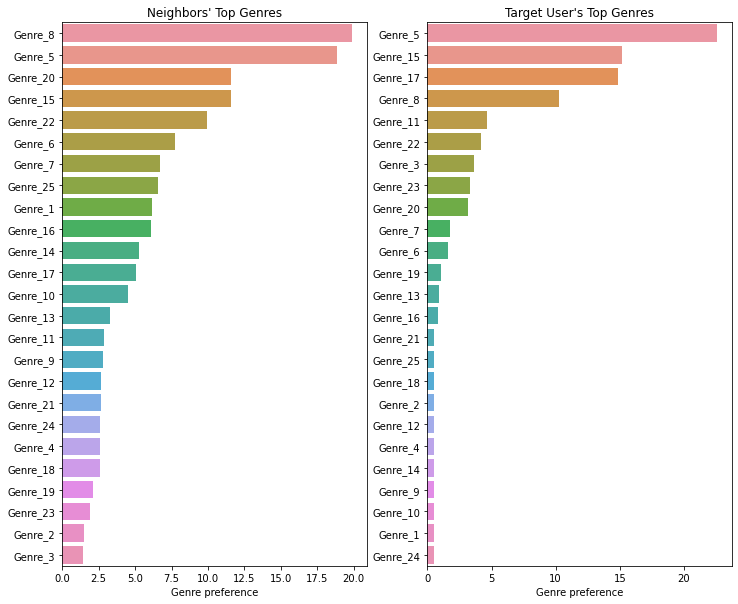

In [12]:
# Show top genres
plot_top_genres(neighbor_user_ratings, target_user_ratings)

In [13]:
# View most popular books among neighbors
neighbors_most_popular(neighbor_user_ratings, 15, min_ratings=2000, write_to_excel=False)

,title,avg_rating,ratings_count,year,percent_similar_users_read,url
45,The Hundred Thousand Kingdoms (Inheritance Tri...,3.81,30194.0,2010,3.3%,https://www.goodreads.com/book/show/6437061-th...
25,In Order to Live: A North Korean Girl's Journe...,4.48,8076.0,2015,1.7%,https://www.goodreads.com/book/show/24611623-i...
4,Assata: An Autobiography,4.47,11057.0,1999,1.7%,https://www.goodreads.com/book/show/100322.Assata
35,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,2016,1.7%,https://www.goodreads.com/book/show/27220736-s...
5,"Avatar: The Last Airbender: The Rift, Part 1 (...",4.33,10667.0,2014,1.7%,https://www.goodreads.com/book/show/18687079-a...
12,Daytripper,4.31,18265.0,2011,1.7%,https://www.goodreads.com/book/show/8477057-da...
18,First They Killed My Father: A Daughter of Cam...,4.30,18580.0,2006,1.7%,https://www.goodreads.com/book/show/4373.First...
56,Totto-chan: The Little Girl at the Window,4.30,14456.0,1996,1.7%,https://www.goodreads.com/book/show/328802.Tot...
40,The Cartel,4.29,9961.0,2015,1.7%,https://www.goodreads.com/book/show/23602561-t...
1,"Age of Myth (The Legends of the First Empire, #1)",4.27,9328.0,2016,1.7%,https://www.goodreads.com/book/show/26863057-a...


In [14]:
# View highest rated books among similar readers
neighbors_top_rated(neighbor_user_ratings, 15, min_ratings=2000, write_to_excel=False)

,title,avg_rating,ratings_count,year,url
25,In Order to Live: A North Korean Girl's Journe...,4.48,8076.0,2015,https://www.goodreads.com/book/show/24611623-i...
4,Assata: An Autobiography,4.47,11057.0,1999,https://www.goodreads.com/book/show/100322.Assata
35,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,2016,https://www.goodreads.com/book/show/27220736-s...
5,"Avatar: The Last Airbender: The Rift, Part 1 (...",4.33,10667.0,2014,https://www.goodreads.com/book/show/18687079-a...
12,Daytripper,4.31,18265.0,2011,https://www.goodreads.com/book/show/8477057-da...
18,First They Killed My Father: A Daughter of Cam...,4.30,18580.0,2006,https://www.goodreads.com/book/show/4373.First...
56,Totto-chan: The Little Girl at the Window,4.30,14456.0,1996,https://www.goodreads.com/book/show/328802.Tot...
40,The Cartel,4.29,9961.0,2015,https://www.goodreads.com/book/show/23602561-t...
1,"Age of Myth (The Legends of the First Empire, #1)",4.27,9328.0,2016,https://www.goodreads.com/book/show/26863057-a...
57,When Christ and His Saints Slept (Henry II an...,4.27,10892.0,1996,https://www.goodreads.com/book/show/43841.When...


In [15]:
# View highest rated books by each of the top genres
show_top_recs_by_genre(
    target=target_user_ratings, 
    others=neighbor_user_ratings, 
    how="KNN", 
    whose_genres="target", 
    n_genres=5, 
    min_score=3.9, 
    min_ratings=400, 
    n_recs=15,
    write_to_excel=False
)

Genre 5: ['history', 'war', 'political', 'account', 'world', 'year', 'country', 'family', 'century', 'people']


,title,avg_rating,ratings_count,url
18,War's Unwomanly Face,4.52,1182.0,https://www.goodreads.com/book/show/4025275-wa...
8,In Order to Live: A North Korean Girl's Journe...,4.48,8076.0,https://www.goodreads.com/book/show/24611623-i...
0,Assata: An Autobiography,4.47,11057.0,https://www.goodreads.com/book/show/100322.Assata
19,Why I Am An Atheist: An Autobiographical Disco...,4.45,866.0,https://www.goodreads.com/book/show/1389596.Wh...
11,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,https://www.goodreads.com/book/show/27220736-s...
6,First They Killed My Father: A Daughter of Cam...,4.30,18580.0,https://www.goodreads.com/book/show/4373.First...
15,The Silk Roads: A New History of the World,4.25,3022.0,https://www.goodreads.com/book/show/25812847-t...
17,Time Stops at Shamli and Other Stories,4.11,1091.0,https://www.goodreads.com/book/show/475218.Tim...
10,Scheisshaus Luck: Surviving the Unspeakable in...,4.09,1049.0,https://www.goodreads.com/book/show/3930572-sc...
5,Em and The Big Hoom,4.07,2282.0,https://www.goodreads.com/book/show/13601144-e...


_____

Genre 15: ['history', 'poem', 'essay', 'text', 'century', 'collection', 'world', 'writing', 'introduction', 'literature']


,title,avg_rating,ratings_count,url
9,Srikanta,4.23,1004.0,https://www.goodreads.com/book/show/1417962.Sr...
2,Feminism is for Everybody: Passionate Politics,4.18,7740.0,https://www.goodreads.com/book/show/168484.Fem...
4,Guns,4.17,3687.0,https://www.goodreads.com/book/show/17284577-guns
11,The Purity Myth: How America's Obsession with ...,4.06,5741.0,https://www.goodreads.com/book/show/4914761-th...
0,Alice in Wonderland,4.03,346530.0,https://www.goodreads.com/book/show/13023.Alic...
8,Octavia's Brood: Science Fiction Stories from ...,3.94,1088.0,https://www.goodreads.com/book/show/23129839-o...
3,"Go Down, Moses",3.93,7562.0,https://www.goodreads.com/book/show/17726.Go_D...
7,Nervous Conditions,3.92,6949.0,https://www.goodreads.com/book/show/158674.Ner...
10,The Affirmation,3.92,893.0,https://www.goodreads.com/book/show/106925.The...
1,Books v. Cigarettes,3.91,2683.0,https://www.goodreads.com/book/show/4064936-bo...


_____

Genre 17: ['alien', 'planet', 'world', 'human', 'ship', 'space', 'war', 'crew', 'mission', 'race']


,title,avg_rating,ratings_count,url
3,Rolling in the Deep (Rolling in the Deep #0.5),3.94,1569.0,https://www.goodreads.com/book/show/23634011-r...
4,"The Clockwork Universe: Isaac Newton, the Roya...",3.91,3763.0,https://www.goodreads.com/book/show/9449985-th...


_____

Genre 8: ['guide', 'people', 'way', 'help', 'practical', 'world', 'experience', 'offer', 'question', 'business']


,title,avg_rating,ratings_count,url
11,The (7L) The Seven Levels of Communication: Go...,4.33,482.0,https://www.goodreads.com/book/show/9858250-th...
18,Totto-chan: The Little Girl at the Window,4.30,14456.0,https://www.goodreads.com/book/show/328802.Tot...
0,"""I Give You My Body . . ."": How I Write Sex Sc...",4.21,481.0,https://www.goodreads.com/book/show/30719827-i...
5,Mountains Beyond Mountains: The Quest of Dr. P...,4.21,53936.0,https://www.goodreads.com/book/show/10235.Moun...
2,Continuous Delivery: Reliable Software Release...,4.15,1748.0,https://www.goodreads.com/book/show/8686650-co...
16,Things No One Will Tell Fat Girls: A Handbook ...,4.06,1488.0,https://www.goodreads.com/book/show/24796533-t...
14,The Lean Startup: How Today's Entrepreneurs Us...,4.04,95622.0,https://www.goodreads.com/book/show/10127019-t...
1,Capital in the Twenty-First Century,4.02,13494.0,https://www.goodreads.com/book/show/18736925-c...
15,The Rational Optimist: How Prosperity Evolves,3.98,4894.0,https://www.goodreads.com/book/show/7776209-th...
10,Thank You for Being Late: An Optimist's Guide ...,3.96,3010.0,https://www.goodreads.com/book/show/26114127-t...


_____

Genre 11: ['fiction', 'collection', 'world', 'literary', 'young', 'funny', 'short', 'comedy', 'horror', 'debut']


,title,avg_rating,ratings_count,url


_____



<a id='Part2'></a>
## Part 2 - Collaborative Filtering Based on Predicted Ratings with Matrix Factorization

In sections <a href='#Part2.1'>2.2</a> and <a href='#Part2.2'>2.2</a> we use singular value decomposition (SVD) to factorize the user-rating matrix generated from the 1500 most similar readers to the target reader, as determined by KNN. SVD decomposes our $m * n$ user-rating matrix $R$ into 3 smaller matrices: $$R = U \Sigma \mathbf{V}^\top$$ where $U$, the left singular vectors, represents an $m * k$ embedding space of user features and $\mathbf{V}^\top$, the right singular vectors, represents a $k * n$ embedding of book features. Estimated ratings come from multiplying the decomposed matrices together to approximate $R$. 

The advantage of SVD is its simplicity and computational efficiency. The disadvantage is that it requires unseen ratings to be encoded as 0 and therefore all predicted ratings on unread books are near zero rather than more realistic values. 

-----

In section <a href='#Part2.3'>2.2</a> we use gradient descent to train user and book embedding matrices $P$ and $Q$. We minimize the loss function: $$L = (r_{ij} - \sum_{k=1}^{K} p_{ik}q_{kj})^2 + \frac{\beta}{2}\sum_{k=1}^{K}(||P||^2 + ||Q||^2)$$ for all $r_{ij} > 0$ using alternating least squares. After training, we reconstruct $R$ matrix by multiplyting $P * Q$. See [here](http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/) for a helpful description of th math.

The advantage of gradient descent is that we can train the model on nonzero ratings (i.e. only for books users have actually rated) and apply it to unread books, which yields realistic rating predictions. The downside is that it is computationally very expensive. Larger user-raing $R$ matrices have exponentially more values than smaller ones, so there is a limit to how many nearest neighbors we can use to generate the full set of book ratings to consider. 

<a id='Part2.1'></a>
#### 2.1 - Factorize User-Rating Matrix with SVD

In [16]:
# Find larger number of similar users than before to get broad pool of potentially relevant books
svd_neighborhood_ratings, target_user_ratings = find_neighbors(1500, target, df_reviews_norm, book_index, df_books)

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_55515/1715287364.py:62: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_55515/1715287364.py:63: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]


In [17]:
# Get unique users and books to slice df_reviews
svd_neighbor_index = svd_neighborhood_ratings["uid"].unique()
svd_neighbor_index = np.append(svd_neighbor_index, target)
svd_neighbor_book_index = svd_neighborhood_ratings["book_index"].unique()
svd_neighbor_book_index = np.append(svd_neighbor_book_index, target_user_ratings["book_index"].unique())

print(f"\nNeighborhood contains {svd_neighborhood_ratings.shape[0]} books")

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, svd_neighbor_book_index]
R = R[svd_neighbor_index, :]


Neighborhood contains 8638 books


In [18]:
# Decompose user ratings matrix R with SVD
U, sigma, Vt = svds(R, k=5)
sigma = np.diag(sigma)

# Convert to sparse matrix
U = sparse.csr_matrix(U)
sigma = sparse.csr_matrix(sigma)
Vt = sparse.csr_matrix(Vt)

<a id='Part2.2'></a>
#### 2.2 - Generate Recommendations by Predicting Ratings

In [19]:
# Get predictions
all_user_predicted_ratings = U.dot(sigma) @ Vt
df_preds = pd.DataFrame(all_user_predicted_ratings.toarray(), columns=svd_neighbor_book_index, index=svd_neighbor_index)\
                .reset_index()

In [20]:
# Get top recs from predictions
def get_recs(preds, target_reader, book_ind, books, write_to_excel=False):
    
    target_pred_books = preds[preds["index"] == target_reader].columns[1:]
    target_pred_ratings = preds[preds["index"] == target_reader].values[0][1:]

    # Put into df with relevant info from df_books
    top_preds = pd.DataFrame({"book_index":target_pred_books, "predicted_rating":target_pred_ratings})\
                    .sort_values(by="predicted_rating", ascending=False)\
                    .merge(book_ind.reset_index(), left_on="book_index", right_on="index")\
                    .merge(
                        books[["book_id", "title", "avg_rating", "ratings_count", "year", "main_genre","url"]],
                        on="book_id"
                    )\
                    .drop(columns=["index", "book_id"])

    # Filter out already read books
    top_preds = top_preds[~top_preds["book_index"].isin(target_user_ratings["book_index"].unique())]
    top_preds.drop(["book_index"], axis=1, inplace=True)

    if write_to_excel == True:
        # Write to excel
        path = wd + "/data/book_recs.xlsx"
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                top_preds.query("avg_rating > 3.9").drop(columns=["predicted_rating", "main_genre"])\
                    .head(50).to_excel(writer, sheet_name="Top by Predicted Score", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                top_preds.query("avg_rating > 3.9").drop(columns=["predicted_rating", "main_genre"])\
                    .head(50).to_excel(writer, sheet_name="Top by Predicted Score", index=False)
        writer.close

    return top_preds

In [21]:
# View books with highest target user predicted score
top_preds = get_recs(df_preds, target, book_index, df_books, write_to_excel=False)
top_preds[["title","avg_rating","predicted_rating","ratings_count","year","url"]]\
                .query("avg_rating > 3.9 & ratings_count > 2000").head(20)

,title,avg_rating,predicted_rating,ratings_count,year,url
6,Night (The Night Trilogy #1),4.30,0.421127,708754.0,1958,https://www.goodreads.com/book/show/1617.Night
7,I Am Malala: The Story of the Girl Who Stood U...,4.07,0.419435,228884.0,2013,https://www.goodreads.com/book/show/17851885-i...
8,"Wool Omnibus (Silo, #1)",4.24,0.312537,83601.0,2012,https://www.goodreads.com/book/show/13453029-w...
11,Bad Feminist,3.91,0.271999,43988.0,2014,https://www.goodreads.com/book/show/18813642-b...
12,"The Pillars of the Earth (Kingsbridge, #1)",4.29,0.255598,471990.0,2002,https://www.goodreads.com/book/show/5043.The_P...
14,"Adulthood Is a Myth (Sarah's Scribbles, #1)",4.15,0.234216,43628.0,2016,https://www.goodreads.com/book/show/25855506-a...
15,Talking as Fast as I Can: From Gilmore Girls t...,4.03,0.233900,35052.0,2016,https://www.goodreads.com/book/show/30253864-t...
16,"Rich Dad, Poor Dad",3.96,0.219367,164543.0,2007,https://www.goodreads.com/book/show/69571.Rich...
19,Understanding Comics: The Invisible Art,3.98,0.214614,80348.0,1994,https://www.goodreads.com/book/show/102920.Und...
22,All the Ugly and Wonderful Things,4.10,0.202358,35002.0,2016,https://www.goodreads.com/book/show/26114135-a...


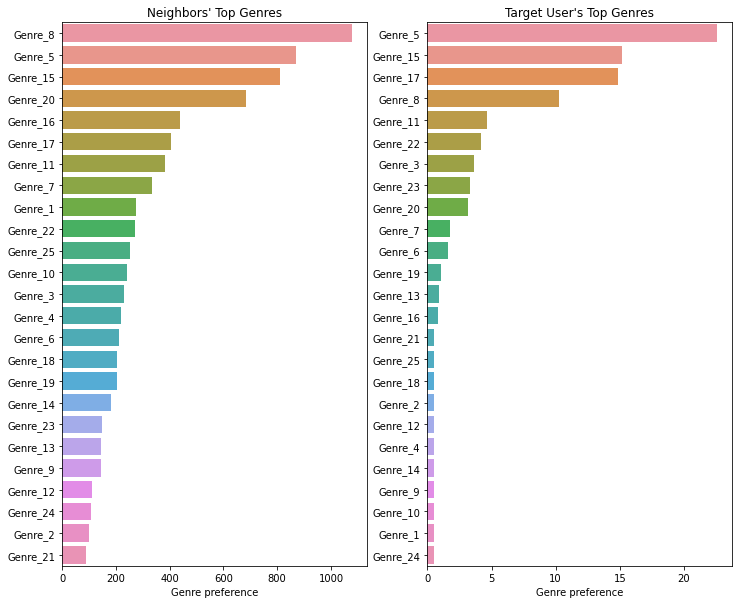

In [22]:
# Show top genres
plot_top_genres(svd_neighborhood_ratings, target_user_ratings)

In [23]:
# View most popular books among neighbors
popular_recs = neighbors_most_popular(svd_neighborhood_ratings, 50, min_ratings=2000, write_to_excel=False)
popular_recs.head(15)

,title,avg_rating,ratings_count,year,percent_similar_users_read,url
650,I Am Malala: The Story of the Girl Who Stood U...,4.07,228884.0,2013,2.3%,https://www.goodreads.com/book/show/17851885-i...
887,Night (The Night Trilogy #1),4.30,708754.0,1958,1.6%,https://www.goodreads.com/book/show/1617.Night
175,Bad Feminist,3.91,43988.0,2014,1.5%,https://www.goodreads.com/book/show/18813642-b...
1880,Wonder (Wonder #1),4.43,255461.0,2012,1.3%,https://www.goodreads.com/book/show/11387515-w...
109,All the Ugly and Wonderful Things,4.10,35002.0,2016,1.3%,https://www.goodreads.com/book/show/26114135-a...
1163,Talking as Fast as I Can: From Gilmore Girls t...,4.03,35052.0,2016,1.3%,https://www.goodreads.com/book/show/30253864-t...
1545,"The Pillars of the Earth (Kingsbridge, #1)",4.29,471990.0,2002,1.2%,https://www.goodreads.com/book/show/5043.The_P...
1883,"Wool Omnibus (Silo, #1)",4.24,83601.0,2012,1.2%,https://www.goodreads.com/book/show/13453029-w...
1400,The Gunslinger,3.98,346978.0,1982,1.2%,https://www.goodreads.com/book/show/43615.The_...
1003,"Rich Dad, Poor Dad",3.96,164543.0,2007,1.2%,https://www.goodreads.com/book/show/69571.Rich...


In [24]:
# Highest rated books among similar readers
top_rated = neighbors_top_rated(svd_neighborhood_ratings, min_ratings=2000, write_to_excel=False)
top_rated.head(15)

,title,avg_rating,ratings_count,year,url
1436,The Indispensable Calvin and Hobbes,4.73,14791.0,1992,https://www.goodreads.com/book/show/24815.The_...
1028,Saga: Book One,4.70,4201.0,2014,https://www.goodreads.com/book/show/22078240-saga
28,A Game of Thrones: The Book of Ice and Fire RP...,4.67,7486.0,2004,https://www.goodreads.com/book/show/4700482-a-...
1697,"The Way of Kings, Part 1 (The Stormlight Archi...",4.67,10191.0,2011,https://www.goodreads.com/book/show/9329354-th...
1327,The Essential Calvin and Hobbes: A Calvin and ...,4.64,95116.0,1988,https://www.goodreads.com/book/show/43070.The_...
271,Calvin and Hobbes,4.61,120371.0,1987,https://www.goodreads.com/book/show/77727.Calv...
608,Holy Bible: New International Version,4.61,42213.0,1985,https://www.goodreads.com/book/show/280111.Hol...
76,"A Voice in the Wind (Mark of the Lion, #1)",4.59,57014.0,1993,https://www.goodreads.com/book/show/95617.A_Vo...
711,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,4.59,92172.0,2012,https://www.goodreads.com/book/show/30.J_R_R_T...
1346,The Feynman Lectures on Physics,4.59,5652.0,1964,https://www.goodreads.com/book/show/5546.The_F...


In [25]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target_user_ratings, 
    svd_neighborhood_ratings, 
    preds=top_preds, 
    how="MF", 
    whose_genres="target", 
    n_genres=5, 
    min_score=4.15, 
    min_ratings=2000, 
    n_recs=20,
    write_to_excel=False
)

Genre 5: ['history', 'war', 'political', 'account', 'world', 'year', 'country', 'family', 'century', 'people']


,title,avg_rating,ratings_count,url
28,Persepolis: The Story of a Childhood (Persepol...,4.23,119470.0,https://www.goodreads.com/book/show/9516.Perse...
44,It's What I Do: A Photographer's Life of Love ...,4.31,6016.0,https://www.goodreads.com/book/show/22571757-i...
57,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,https://www.goodreads.com/book/show/27220736-s...
58,Complications: A Surgeon's Notes on an Imperfe...,4.24,26885.0,https://www.goodreads.com/book/show/4477.Compl...
184,Open,4.18,48230.0,https://www.goodreads.com/book/show/6480781-open
200,The New Jim Crow: Mass Incarceration in the Ag...,4.49,24694.0,https://www.goodreads.com/book/show/6792458-th...
202,Our Revolution: A Future to Believe In,4.29,2430.0,https://www.goodreads.com/book/show/31741420-o...
232,"March: Book One (March, #1)",4.34,21092.0,https://www.goodreads.com/book/show/17346698-m...
393,In Order to Live: A North Korean Girl's Journe...,4.48,8076.0,https://www.goodreads.com/book/show/24611623-i...
396,First They Killed My Father: A Daughter of Cam...,4.30,18580.0,https://www.goodreads.com/book/show/4373.First...


_____

Genre 15: ['history', 'poem', 'essay', 'text', 'century', 'collection', 'world', 'writing', 'introduction', 'literature']


,title,avg_rating,ratings_count,url
33,Palestine,4.20,10082.0,https://www.goodreads.com/book/show/769712.Pal...
45,"Short Stories from Hogwarts of Heroism, Hardsh...",4.23,16961.0,https://www.goodreads.com/book/show/31538635-s...
56,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,95353.0,https://www.goodreads.com/book/show/5544.Surel...
63,Sounds Like Me: My Life (So Far) in Song,4.26,3867.0,https://www.goodreads.com/book/show/25434361-s...
111,Her Smoke Rose Up Forever,4.22,2539.0,https://www.goodreads.com/book/show/27059.Her_...
148,Transformations,4.21,4691.0,https://www.goodreads.com/book/show/47734.Tran...
186,The World of Ice & Fire: The Untold History of...,4.26,12952.0,https://www.goodreads.com/book/show/17345242-t...
242,Feminism is for Everybody: Passionate Politics,4.18,7740.0,https://www.goodreads.com/book/show/168484.Fem...
276,Why Evolution Is True,4.16,15226.0,https://www.goodreads.com/book/show/4005310-wh...
313,The Library of Babel,4.47,3929.0,https://www.goodreads.com/book/show/172366.The...


_____

Genre 17: ['alien', 'planet', 'world', 'human', 'ship', 'space', 'war', 'crew', 'mission', 'race']


,title,avg_rating,ratings_count,url
91,"The Walking Dead, Compendium 1",4.43,58434.0,https://www.goodreads.com/book/show/6465707-th...
360,The Hyperion Omnibus: Hyperion / The Fall of H...,4.41,2254.0,https://www.goodreads.com/book/show/3943.The_H...
385,Judas Unchained,4.30,21306.0,https://www.goodreads.com/book/show/45244.Juda...
397,The Dreaming Void,4.18,16512.0,https://www.goodreads.com/book/show/866136.The...
482,"I, Robot (Robot #0.1)",4.17,201196.0,https://www.goodreads.com/book/show/41804.I_Robot
816,Lost Stars,4.25,9512.0,https://www.goodreads.com/book/show/25067046-l...
868,"Wolf by Wolf (Wolf by Wolf, #1)",4.28,9710.0,https://www.goodreads.com/book/show/24807186-w...
1186,The Butter Battle Book,4.18,10575.0,https://www.goodreads.com/book/show/275325.The...
1569,Maus I: A Survivor's Tale: My Father Bleeds Hi...,4.35,189288.0,https://www.goodreads.com/book/show/15196.Maus_I
2109,South: The Story of Shackleton's Last Expediti...,4.21,4715.0,https://www.goodreads.com/book/show/143999.South


_____

Genre 8: ['guide', 'people', 'way', 'help', 'practical', 'world', 'experience', 'offer', 'question', 'business']


,title,avg_rating,ratings_count,url
77,Harry Potter and the Methods of Rationality,4.38,8691.0,https://www.goodreads.com/book/show/10016013-h...
94,Deep Work: Rules for Focused Success in a Dist...,4.19,15605.0,https://www.goodreads.com/book/show/25744928-d...
106,Ina May's Guide to Childbirth,4.41,12338.0,https://www.goodreads.com/book/show/32127.Ina_...
108,"Delusions of Gender: How Our Minds, Society, a...",4.16,4207.0,https://www.goodreads.com/book/show/8031168-de...
140,Why Does He Do That?: Inside the Minds of Angr...,4.47,3477.0,https://www.goodreads.com/book/show/224552.Why...
192,"Creativity, Inc.: Overcoming the Unseen Forces...",4.24,27705.0,https://www.goodreads.com/book/show/18077903-c...
195,The Hard Thing About Hard Things: Building a B...,4.20,20745.0,https://www.goodreads.com/book/show/18176747-t...
222,"Zen Mind, Beginner's Mind: Informal Talks on Z...",4.23,25179.0,https://www.goodreads.com/book/show/402843.Zen...
275,Algorithms to Live By: The Computer Science of...,4.16,4639.0,https://www.goodreads.com/book/show/25666050-a...
427,Wit,4.20,10771.0,https://www.goodreads.com/book/show/171201.Wit


_____

Genre 11: ['fiction', 'collection', 'world', 'literary', 'young', 'funny', 'short', 'comedy', 'horror', 'debut']


,title,avg_rating,ratings_count,url
284,Asterios Polyp,4.19,20053.0,https://www.goodreads.com/book/show/4070095-as...
325,The Essential Dykes to Watch Out For,4.36,6979.0,https://www.goodreads.com/book/show/3189884-th...
821,Love's Executioner and Other Tales of Psychoth...,4.18,14376.0,https://www.goodreads.com/book/show/21027.Love...
1395,The Exploits of Sherlock Holmes,4.41,26933.0,https://www.goodreads.com/book/show/76104.The_...
1644,A Manual for Cleaning Women: Selected Stories,4.17,6863.0,https://www.goodreads.com/book/show/22929586-a...
1782,Sherlock Holmes: The Complete Novels and Stori...,4.45,18729.0,https://www.goodreads.com/book/show/3581.Sherl...
1907,What Matters Most is How Well You Walk Through...,4.30,4351.0,https://www.goodreads.com/book/show/632901.Wha...
3596,A Supposedly Fun Thing I'll Never Do Again: E...,4.28,23746.0,https://www.goodreads.com/book/show/6748.A_Sup...
3687,A Sound of Thunder and Other Stories,4.21,4610.0,https://www.goodreads.com/book/show/50014.A_So...
5567,"Beautiful Outlaw: Experiencing the Playful, Di...",4.31,2633.0,https://www.goodreads.com/book/show/12079560-b...


_____



<a id='Part2.3'></a>
### 2.3 Matrix Factorization with Gradient Descent

In [35]:
# Find larger number of similar users than before to get broad pool of potentially relevant books
gd_neighborhoodhood_ratings, target_user_ratings = find_neighbors(1000, target, df_reviews_norm, book_index, df_books)

# Get unique users and books to slice df_reviews
gd_neighborhood_index = gd_neighborhoodhood_ratings["uid"].unique()
gd_neighborhood_index = np.append(gd_neighborhood_index, target)
gd_neighborhood_book_index = gd_neighborhoodhood_ratings["book_index"].unique()
gd_neighborhood_book_index = np.append(gd_neighborhood_book_index, target_user_ratings["book_index"].unique())
print(f"\nNeighborhood contains {gd_neighborhood_book_index.shape[0]} books")

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, gd_neighborhood_book_index]
R = R[gd_neighborhood_index, :]
R = R.toarray()

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_55515/1715287364.py:62: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_55515/1715287364.py:63: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]



Neighborhood contains 3865 books


In [36]:
# Function to train embedding matrices using alternating least squares (ALS) and make predictions 
def matrix_factorization(R, k_components=5, steps=4000, lr=0.0002, beta=0.03, decay=True, verbose=0):
    """
    Uses gradient descent to train matrix factorization algorithm

    Args:
        R: Utility matrix of user item ratings         
        k: Number of latent features
        steps: Number of epochs to run training
        lr: Learning rate
        beta: Regularization strength
        verbose: Prints updates if 1

    Returns:
        Predictions, User Embeddings, Item Embdeddings
    """

    # Initialize random values for user (P) and book (Q) embedding matrices    
    P = np.random.rand(R.shape[0],k_components)
    Q = np.random.rand(R.shape[1],k_components).T

    # Get nonzero ratings to perform operations on
    r_0 = np.where(R > 0) # Find indices where rating > 0
    i = r_0[0] # Get row indices where rating > 0
    j = r_0[1] # Get column indices where rating > 0 
    nonzero_ratings = R[i,j]

    # For each step calc residual and take step down gradient
    for step in range(steps): 
        resid = nonzero_ratings - (P @ Q)[i,j] # residual is value - r_hat       
        for k in range(k_components): # for each component (latent feature)                
            P[i,k] = P[i,k] + lr * (2 * resid * Q[k,j] - beta * P[i,k]) # Update P by step in gradient                             
            Q[k,j] = Q[k,j] + lr * (2 * resid * P[i,k] - beta * Q[k,j]) # Update Q by step in gradient            

        # Calculate error every n steps                  
        if ((step + 1) % 1000 == 0) | (step == 0): 
            error = 0 # Initialize counter for error  
            error = error + np.sum(pow(resid, 2)) # Add to error
            for k in range(k_components): # for each component (latent feature)                             
                error = error + (beta/2) * np.sum(pow(P[i,k],2) + pow(Q[k,j],2)) # Add regularized term            

            # View progress
            if verbose == 1:
                print(f"Step: {step + 1}, error: {error:.2f}, lr: {lr:.5f}") 
            
            # Set learning rate to decay until 0.00002
            if decay == True:
                if lr > 0.00002:                                
                    lr = lr / 2
    
    # Get predictions
    preds = np.dot(P, Q)

    return preds, P, Q.T

In [37]:
# Train model and get predictions
preds, user_embed, item_embed = matrix_factorization(
                                    R, 
                                    k_components=70, 
                                    lr=0.009, 
                                    beta=0.07,
                                    decay=True, 
                                    steps=8000, 
                                    verbose=1
                                )
df_preds_GD = pd.DataFrame(preds, columns=gd_neighborhood_book_index, index=gd_neighborhood_index)\
                .reset_index()

Step: 1, error: 1067329.61, lr: 0.00900
Step: 1000, error: 6152.55, lr: 0.00450
Step: 2000, error: 4627.68, lr: 0.00225
Step: 3000, error: 4220.79, lr: 0.00112
Step: 4000, error: 4076.17, lr: 0.00056
Step: 5000, error: 4015.95, lr: 0.00028
Step: 6000, error: 3988.58, lr: 0.00014
Step: 7000, error: 3975.55, lr: 0.00007
Step: 8000, error: 3969.20, lr: 0.00004


In [42]:
# View top predicted ratings
top_preds_GD = get_recs(df_preds_GD, target, book_index, df_books, write_to_excel=False)
top_preds_GD[["title","avg_rating","predicted_rating","ratings_count","year","url"]]\
                .query("avg_rating > 4.1 & ratings_count > 2000").head(20)

,title,avg_rating,predicted_rating,ratings_count,year,url
25,Avatar: The Last Airbender (The Art of the Ani...,4.50,4.863171,15507.0,2010,https://www.goodreads.com/book/show/7642606-av...
26,"Avatar: The Last Airbender: The Rift, Part 1 (...",4.33,4.774560,10667.0,2014,https://www.goodreads.com/book/show/18687079-a...
33,The False Prince (The Ascendance Trilogy #1),4.23,4.609343,51292.0,2012,https://www.goodreads.com/book/show/12432220-t...
35,"Complete Poems, 1904-1962",4.35,4.546213,18787.0,1994,https://www.goodreads.com/book/show/26596.Comp...
42,"Far from the Tree: Parents, Children, and the ...",4.27,4.456231,12131.0,2012,https://www.goodreads.com/book/show/13547504-f...
44,Traveling Light: Releasing the Burdens You Wer...,4.23,4.424799,8483.0,2006,https://www.goodreads.com/book/show/56636.Trav...
45,Most Dangerous: Daniel Ellsberg and the Secret...,4.24,4.422484,2888.0,2015,https://www.goodreads.com/book/show/23310694-m...
54,"Fat Chance: Beating the Odds Against Sugar, Pr...",4.13,4.332056,3148.0,2012,https://www.goodreads.com/book/show/14481524-f...
55,Moxie,4.49,4.330869,2030.0,2017,https://www.goodreads.com/book/show/33163378-m...
58,Y: The Last Man - The Deluxe Edition Book One,4.36,4.316201,10549.0,2008,https://www.goodreads.com/book/show/3710603-y


In [39]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target_user_ratings, 
    gd_neighborhoodhood_ratings, 
    preds=top_preds_GD, 
    how="MF", 
    whose_genres="target", 
    n_genres=5, 
    min_score=4.15, 
    min_ratings=2000, 
    n_recs=20,
    write_to_excel=False
)

Genre 5: ['history', 'war', 'political', 'account', 'world', 'year', 'country', 'family', 'century', 'people']


,title,avg_rating,ratings_count,url
61,"American Tabloid (Underworld USA, #1)",4.21,10342.0,https://www.goodreads.com/book/show/36064.Amer...
116,The Great Dune Trilogy,4.36,52034.0,https://www.goodreads.com/book/show/53764.The_...
166,"March: Book One (March, #1)",4.34,21092.0,https://www.goodreads.com/book/show/17346698-m...
178,We Wish to Inform You That Tomorrow We Will Be...,4.29,19564.0,https://www.goodreads.com/book/show/11472.We_W...
212,Open,4.18,48230.0,https://www.goodreads.com/book/show/6480781-open
246,Destiny Disrupted: A History of the World thro...,4.34,3697.0,https://www.goodreads.com/book/show/6240926-de...
264,The Girl with Seven Names: A North Korean Defe...,4.45,8293.0,https://www.goodreads.com/book/show/25362017-t...
352,"Dear Leader: Poet, Spy, Escapee—A Look Inside ...",4.29,2732.0,https://www.goodreads.com/book/show/20736640-d...
377,The Silk Roads: A New History of the World,4.25,3022.0,https://www.goodreads.com/book/show/25812847-t...
413,No Ordinary Time: Franklin and Eleanor Rooseve...,4.19,28368.0,https://www.goodreads.com/book/show/18728.No_O...


_____

Genre 15: ['history', 'poem', 'essay', 'text', 'century', 'collection', 'world', 'writing', 'introduction', 'literature']


,title,avg_rating,ratings_count,url
35,"Complete Poems, 1904-1962",4.35,18787.0,https://www.goodreads.com/book/show/26596.Comp...
45,Most Dangerous: Daniel Ellsberg and the Secret...,4.24,2888.0,https://www.goodreads.com/book/show/23310694-m...
80,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,95353.0,https://www.goodreads.com/book/show/5544.Surel...
89,"Notes from Underground, White Nights, The Drea...",4.17,66680.0,https://www.goodreads.com/book/show/17876.Note...
113,Her Smoke Rose Up Forever,4.22,2539.0,https://www.goodreads.com/book/show/27059.Her_...
118,"The Camera (Ansel Adams Photography, #1)",4.22,2663.0,https://www.goodreads.com/book/show/20501.The_...
140,The Fire This Time: A New Generation Speaks ab...,4.35,2309.0,https://www.goodreads.com/book/show/28505023-t...
315,Natasha's Dance: A Cultural History of Russia,4.16,2039.0,https://www.goodreads.com/book/show/97401.Nata...
350,Collected Poems,4.26,5180.0,https://www.goodreads.com/book/show/321538.Col...
402,The Complete Paintings and Drawings,4.25,7033.0,https://www.goodreads.com/book/show/1757416.Th...


_____

Genre 17: ['alien', 'planet', 'world', 'human', 'ship', 'space', 'war', 'crew', 'mission', 'race']


,title,avg_rating,ratings_count,url
197,"Avatar: The Last Airbender: The Promise, Part ...",4.24,18987.0,https://www.goodreads.com/book/show/12413836-a...
326,"Wolf by Wolf (Wolf by Wolf, #1)",4.28,9710.0,https://www.goodreads.com/book/show/24807186-w...
593,"The Walking Dead, Compendium 1",4.43,58434.0,https://www.goodreads.com/book/show/6465707-th...
631,The Evolutionary Void,4.26,13729.0,https://www.goodreads.com/book/show/7438179-th...
875,"Kings of the Wyld (The Band, #1)",4.42,2285.0,https://www.goodreads.com/book/show/30841984-k...
934,The Abyss Beyond Dreams,4.21,4944.0,https://www.goodreads.com/book/show/20697413-t...
1026,The Butter Battle Book,4.18,10575.0,https://www.goodreads.com/book/show/275325.The...
1272,The Hyperion Omnibus: Hyperion / The Fall of H...,4.41,2254.0,https://www.goodreads.com/book/show/3943.The_H...
1577,"I, Robot (Robot #0.1)",4.17,201196.0,https://www.goodreads.com/book/show/41804.I_Robot
1679,Foundation / Foundation and Empire / Second Fo...,4.35,3316.0,https://www.goodreads.com/book/show/278097.Fou...


_____

Genre 8: ['guide', 'people', 'way', 'help', 'practical', 'world', 'experience', 'offer', 'question', 'business']


,title,avg_rating,ratings_count,url
126,Come as You Are: The Surprising New Science th...,4.23,3258.0,https://www.goodreads.com/book/show/22609341-c...
133,The Power of Vulnerability: Teachings of Authe...,4.57,3778.0,https://www.goodreads.com/book/show/23500254-t...
179,Harry Potter and the Methods of Rationality,4.38,8691.0,https://www.goodreads.com/book/show/10016013-h...
189,"The Story of the Human Body: Evolution, Health...",4.21,2759.0,https://www.goodreads.com/book/show/17736859-t...
203,The Power of a Praying Woman,4.38,9867.0,https://www.goodreads.com/book/show/18054709-t...
209,The Go-Giver: A Little Story About a Powerful ...,4.33,7145.0,https://www.goodreads.com/book/show/1873060.Th...
243,Prayer: Does It Make Any Difference?,4.16,4445.0,https://www.goodreads.com/book/show/53827.Prayer
290,Life Without Limits,4.16,4367.0,https://www.goodreads.com/book/show/8639945-li...
297,Intercessory Prayer: How God Can Use Your Pray...,4.33,3208.0,https://www.goodreads.com/book/show/180733.Int...
305,"Purification of the Heart: Signs, Symptoms and...",4.49,2078.0,https://www.goodreads.com/book/show/272724.Pur...


_____

Genre 11: ['fiction', 'collection', 'world', 'literary', 'young', 'funny', 'short', 'comedy', 'horror', 'debut']


,title,avg_rating,ratings_count,url
453,Asterios Polyp,4.19,20053.0,https://www.goodreads.com/book/show/4070095-as...
533,The Essential Dykes to Watch Out For,4.36,6979.0,https://www.goodreads.com/book/show/3189884-th...
844,Sherlock Holmes: The Complete Novels and Stori...,4.45,18729.0,https://www.goodreads.com/book/show/3581.Sherl...
1290,Tales,4.37,2100.0,https://www.goodreads.com/book/show/36313.Tales
1623,A Supposedly Fun Thing I'll Never Do Again: E...,4.28,23746.0,https://www.goodreads.com/book/show/6748.A_Sup...
1801,The Faraway Nearby,4.19,3409.0,https://www.goodreads.com/book/show/16158561-t...
1873,Love's Executioner and Other Tales of Psychoth...,4.18,14376.0,https://www.goodreads.com/book/show/21027.Love...
2432,A Manual for Cleaning Women: Selected Stories,4.17,6863.0,https://www.goodreads.com/book/show/22929586-a...
3822,"Beautiful Outlaw: Experiencing the Playful, Di...",4.31,2633.0,https://www.goodreads.com/book/show/12079560-b...


_____

